# Decision Tree Regression

First we import all of our data and create the dropped column.

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

DATA="/Users/aguang/CORE/tippingpoint/tippingpoint/data"
df_dv = pd.read_csv(os.path.join(DATA,"df_dv.dat"))
df_gc = pd.read_csv(os.path.join(DATA,"df_gc.dat"))
df_subject = pd.read_csv(os.path.join(DATA,"df_subject.dat"))
full_df = pd.read_csv(os.path.join(DATA,"full_df.dat"))
dropped = full_df.drop(columns=["impChange","impRise","impFall","impPeriodic","liwcCause","liwcFocusPre","liwcFocusFut","liwcRelativ","liwcTime"]).dropna()

In [4]:
from sklearn import tree
#feature_cols = ["risingBefore", "cannotSeeAfter", "downOverall", "bellOverall", "complexOverall", "expExec", "liwcPosemo", "liwcNegemo"]
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(dropped.iloc[:,5:],dropped.tp)

In [42]:
#making a plot
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
import collections

def decision_tree_image(decision_tree, features, file=None):
    dot_data = StringIO()
    tree.export_graphviz(decision_tree,out_file=dot_data,feature_names=features,
                         class_names=["No TP","TP"], filled=True, rounded=True,
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    
    colors = ('lightblue', 'orange')
    edges = collections.defaultdict(list)
    
    #for edge in graph.get_edge_list():
    #    edges[edge.get_source()].append(int(edge.get_destination()))
        
    #for edge in edges:
    #    edges[edge].sort()
    #    for i in range(2):
    #        dest = graph.get_node(str(edges[edge][i]))[0]
    #        dest.set_fillcolor(colors[i])
    
    if file:
        graph.write_png(file)
    img = Image(graph.create_png())
    return(img)

For visualization purposes we look at a tree with depth 4. Interpreting the tree:
 * Variable in question. Go left if true and right if false.
 * Gini is gini impurity of node. If gini is close to 0 then there is essentially no uncertainty left. Otherwise there are still some potential splits to be made. More specifically, it is the probability we classify a random point in the set incorrectly, if we classified it according to the distribution of class labels.
 * Sample is number of samples for that node
 * Value is count of samples in each class that have reached that node. First class is no TP, and second class is yes TP. This is not the same as their split within the variable in question.
 * Class is the class with the larger number of responses, either TP or No TP. 
 * Orange is did not declare TP, blue is declared TP.
 
What's interesting about this tree?

 * `risingBefore` is first level node, still most significant split
 * `expExec` and `liwcPosemo` are second level nodes
 * Can see that if graph is NOT rising before, then for the most part points are not declared as tipping points
 * If graph IS rising before, then `expExec=0` or `expExec=1` determines whether subjects are more likely to rate points as TPs (less experienced) or not as TPs (more experienced). Suggests interaction between `risingBefore` and `expExec`, which we did not model in the logistic regression.

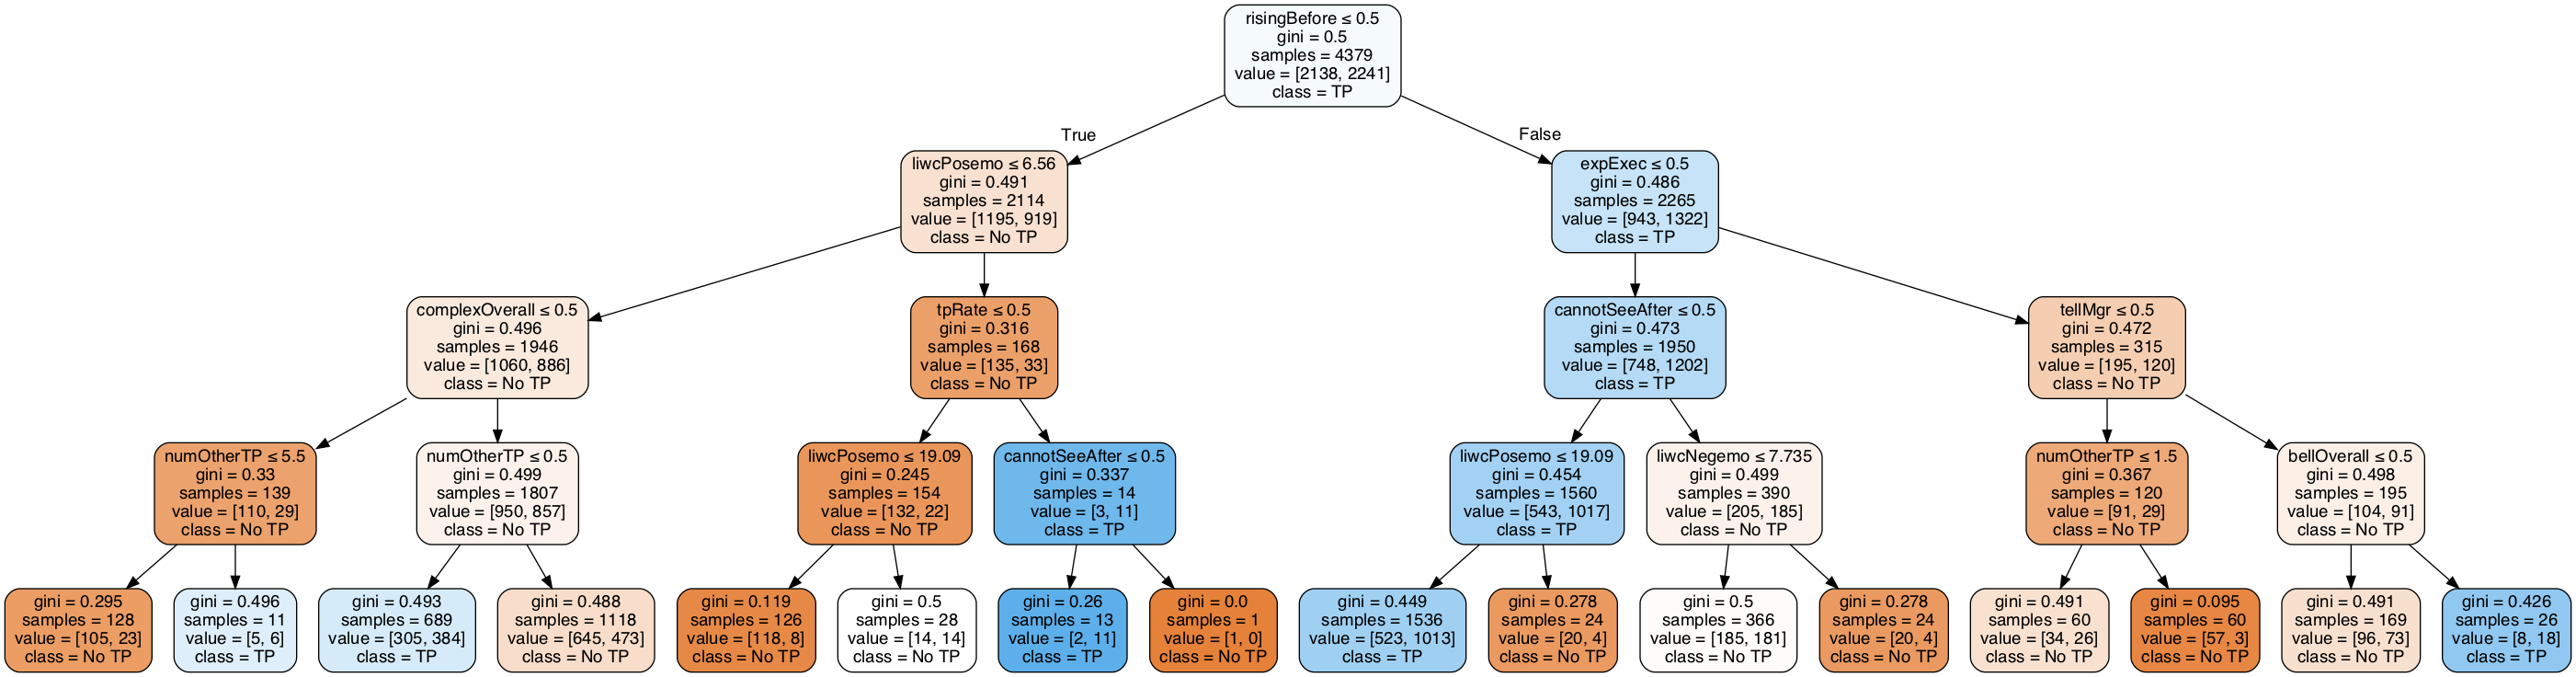

In [43]:
decision_tree_image(clf, dropped.columns[5:], "Figures/decision_tree_all.png")

Can compute feature importances from decision trees. [From sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_), feature importances are computed as the normalized total reduction of the criterion brought by the future, aka how much Gini impurity is reduced. Mathematically, at each node this corresponds to:

$$\text{importance} = N_t / N * (\text{impurity} - R(N_t) / N_t * \text{right_impurity} - L(N_t) / N_t * \text{left_impurity} $$

where $N_t$ is the number of samples at that node, $R(N_t)$ is the number of samples in the right child of the node, and $L(N_t)$ is the number of samples in the left child of the node.

The feature importance is then the sum of the importances at nodes where the feature is used, normalized by the total number of samples.

Sklearn provides code to turn feature importances into a plot.

In [186]:
importances = clf.feature_importances_
colnames = dropped.iloc[:,5:].columns
df_feature_importance = pd.DataFrame({'feature': colnames,
                                      'importance': importances},
                                     index=colnames).sort_values('importance', ascending=False)
df_feature_importance

,feature,importance
risingBefore,risingBefore,0.229211
liwcPosemo,liwcPosemo,0.193405
expExec,expExec,0.142069
numOtherTP,numOtherTP,0.127062
cannotSeeAfter,cannotSeeAfter,0.099234
complexOverall,complexOverall,0.086058
tpRate,tpRate,0.050114
tellMgr,tellMgr,0.035536
liwcNegemo,liwcNegemo,0.022878
bellOverall,bellOverall,0.014433


In [11]:
def importance_plot(classifier, df, classtype="RandomForest", file=None):
    importances = classifier.feature_importances_
    if classtype=="DecisionTree":
        pass
    else:
        std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
        
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(df.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.tight_layout()
    plt.figure()
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title("Feature importances")
    if classtype=="DecisionTree":
        plt.bar(range(df.shape[1]), importances[indices],
               color="r", align="center")
    else:
        plt.bar(range(df.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
    plt.xticks(range(df.shape[1]), df.columns[indices],rotation=90)
    plt.xlim([-1, df.shape[1]])
    if file is not None:
        plt.savefig(file)
    plt.show()

Feature ranking:
1. feature 0 (0.229211)
2. feature 13 (0.193405)
3. feature 6 (0.142069)
4. feature 12 (0.127062)
5. feature 1 (0.099234)
6. feature 4 (0.086058)
7. feature 8 (0.050114)
8. feature 11 (0.035536)
9. feature 14 (0.022878)
10. feature 3 (0.014433)
11. feature 9 (0.000000)
12. feature 15 (0.000000)
13. feature 7 (0.000000)
14. feature 10 (0.000000)
15. feature 5 (0.000000)
16. feature 2 (0.000000)
17. feature 16 (0.000000)


<Figure size 432x288 with 0 Axes>

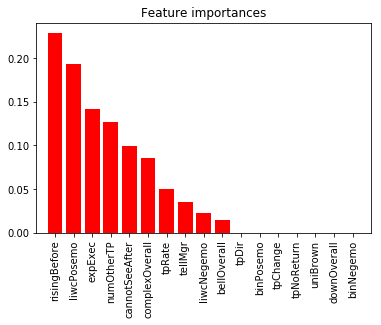

In [12]:
importance_plot(clf,dropped.iloc[:,5:],"DecisionTree","Figures/dt_importance.pdf")

Key takeaways:

 * `risingBefore`, `liwcPosemo`, `expExec`, `numOtherTP`, `cannotSeeAfter`, `complexOverall` appear to be important features for the decision tree.
 * Most of it is consistent with the logistic regression, however `numOtherTP` and `complexOverall` are additional important features in the decision tree that we did not see as significant in logistic regression.
 * Should look more into `numOtherTP`, and `complexOverall`, as they represent **Hypotheses 4, 7**.
 * `risingBefore` appears to interact with `expExec` but is also significant on its own

# Can we predict how individuals will respond to graphs?

Having found support for most of our hypotheses, we now turn to whether we can predict how individuals will respond to graphs. We do this with random forests, in 2 ways: by splitting on userID, and by splitting on graphID. See below.

## Random forest by splitting on user ID

This poses the question: given a new individual, can we predict how they will categorize a graph, and what features are important? The important features are quite different; however the accuracy is also not very good.

In [14]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier

def shuffle_split(groups,X=dropped.iloc[:,5:],y=dropped.iloc[:,2],
                  test_size=0.2,n_splits=2):
    np.random.seed(3851)
    train_inds, test_inds = next(GroupShuffleSplit(test_size,
                                                   n_splits).split(X,
                                                                  y,
                                                                  groups))
    return train_inds, test_inds

train_inds, test_inds = next(GroupShuffleSplit(test_size=0.2,
                                               n_splits=2).split(X=dropped.iloc[:,5:],y=dropped.iloc[:,2], groups=dropped['subj']))

X_train = dropped.iloc[train_inds,5:]
X_test = dropped.iloc[test_inds, 5:]
y_train = dropped.iloc[train_inds,2]
y_test = dropped.iloc[test_inds,2]

classifier = RandomForestClassifier(n_estimators=100)
classifier = classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

From the confusion matrix and the accuracy score, as well as the counts we can see that the model does almost no better than at random.

In [104]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", cm)

# Accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: ", acc)

y_test.value_counts()/len(y_test)

Confusion matrix:  [[257 221]
 [171 250]]
Accuracy score:  0.5639599555061179


0.0    0.531702
1.0    0.468298
Name: tp, dtype: float64

Although the model does almost no better than random, what's interesting is that the driving feature from the feature importance plot is `numOtherTPs`.

Feature ranking:
1. feature 12 (0.277967)
2. feature 14 (0.103108)
3. feature 13 (0.093121)
4. feature 0 (0.071828)
5. feature 9 (0.061056)
6. feature 10 (0.056489)
7. feature 1 (0.053252)
8. feature 8 (0.049152)
9. feature 11 (0.047479)
10. feature 5 (0.034764)
11. feature 4 (0.034502)
12. feature 2 (0.033276)
13. feature 6 (0.031196)
14. feature 3 (0.026815)
15. feature 7 (0.025996)


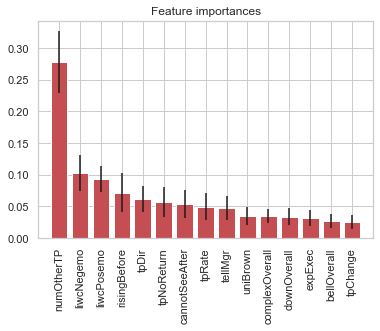

In [205]:
#importance_plot(classifier, X_test, file="Figures/rf_subj.pdf")
importance_plot(classifier, X_test, file="Figures/rf_subj.png")

In [206]:
acc_cross = cross_val_score(estimator = classifier,
                            X = X_train,
                            y=y_train, cv = 10)
print("Accuracies for 10 folds: ", acc_cross)
print("mean: ", acc_cross.mean())
print("sd: ", acc_cross.std())

Accuracies for 10 folds:  [0.45114943 0.58333333 0.66091954 0.6408046  0.5316092  0.46551724
 0.5545977  0.68678161 0.45977011 0.58333333]
mean:  0.5617816091954023
sd:  0.08093302934199806


# Random forest by splitting on graphid

This asks the question, given a new graph, can we predict what it will be marked as, and what features are predictive? This remains similar to splitting on subject, but is much more accurate at 75% accuracy compared to at random which would have been 50% accuracy.

Confusion matrix:  [[390  64]
 [159 293]]
Accuracy score:  0.7538631346578366
proportion:  0.0    0.501104
1.0    0.498896
Name: tp, dtype: float64
Feature ranking:
1. feature 12 (0.283301)
2. feature 13 (0.077801)
3. feature 0 (0.071560)
4. feature 8 (0.059426)
5. feature 14 (0.059090)
6. feature 9 (0.057969)
7. feature 11 (0.052517)
8. feature 10 (0.049803)
9. feature 1 (0.041345)
10. feature 4 (0.041266)
11. feature 5 (0.037953)
12. feature 2 (0.035821)
13. feature 6 (0.030815)
14. feature 3 (0.028469)
15. feature 7 (0.025101)
16. feature 15 (0.024765)
17. feature 16 (0.022997)


<Figure size 432x288 with 0 Axes>

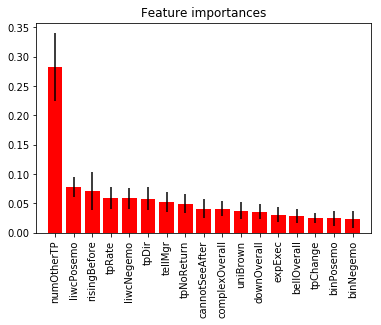

In [21]:
np.random.seed(3851)
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.2,
                                               n_splits=2).split(X=dropped.iloc[:,5:],y=dropped.iloc[:,2], groups=dropped['graphid']))
X_train = dropped.iloc[train_inds,5:]
X_test = dropped.iloc[test_inds, 5:]
y_train = dropped.iloc[train_inds,2]
y_test = dropped.iloc[test_inds,2]

classifier_gid = RandomForestClassifier(n_estimators=100)
classifier_gid = classifier_gid.fit(X_train, y_train)

y_pred = classifier_gid.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", cm)

# Accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: ", acc)

print("proportion: ", y_test.value_counts()/len(y_test))

importance_plot(classifier_gid,X_test,file="Figures/rf_graphid.png")

#importance_plot(classifier_gid,X_test,file="Figures/rf_graphid.pdf")

Again, what's interesting here is that the most important feature by far is `numOtherTP`. So it seems that the number of other TPs a subject sees is a very good predictor of how they will classify a point on a new graph provided, which makes sense if you think about it.

This concludes all of the material I have for now.

# Scattered notes

These are scattered notes from exploratory data analysis. They are not particularly organized and are not meant to be followed. Feel free to browse through but don't expect any kind of explanation.

## Scatterplot of most important feature vs 2nd most important

Need to discuss how to better show plots. First one is basic scatter plot, second is treating numTP as a categorical variable, however liwcPosemo may as well be one too since these are repeated features for students.

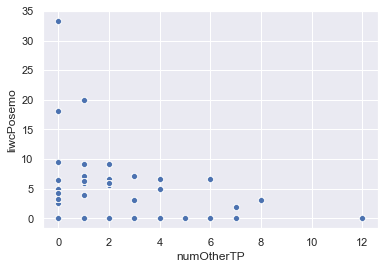

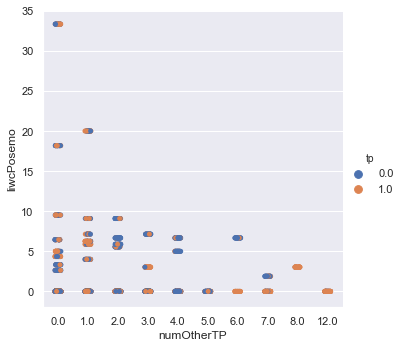

In [124]:
import seaborn as sns; sns.set()
ax = sns.scatterplot(x="numOtherTP", y="liwcPosemo", data=dropped)
#ax.set_ylabel("Diverging")
sns.catplot(x="numOtherTP", y="liwcPosemo", hue="tp", data=dropped)

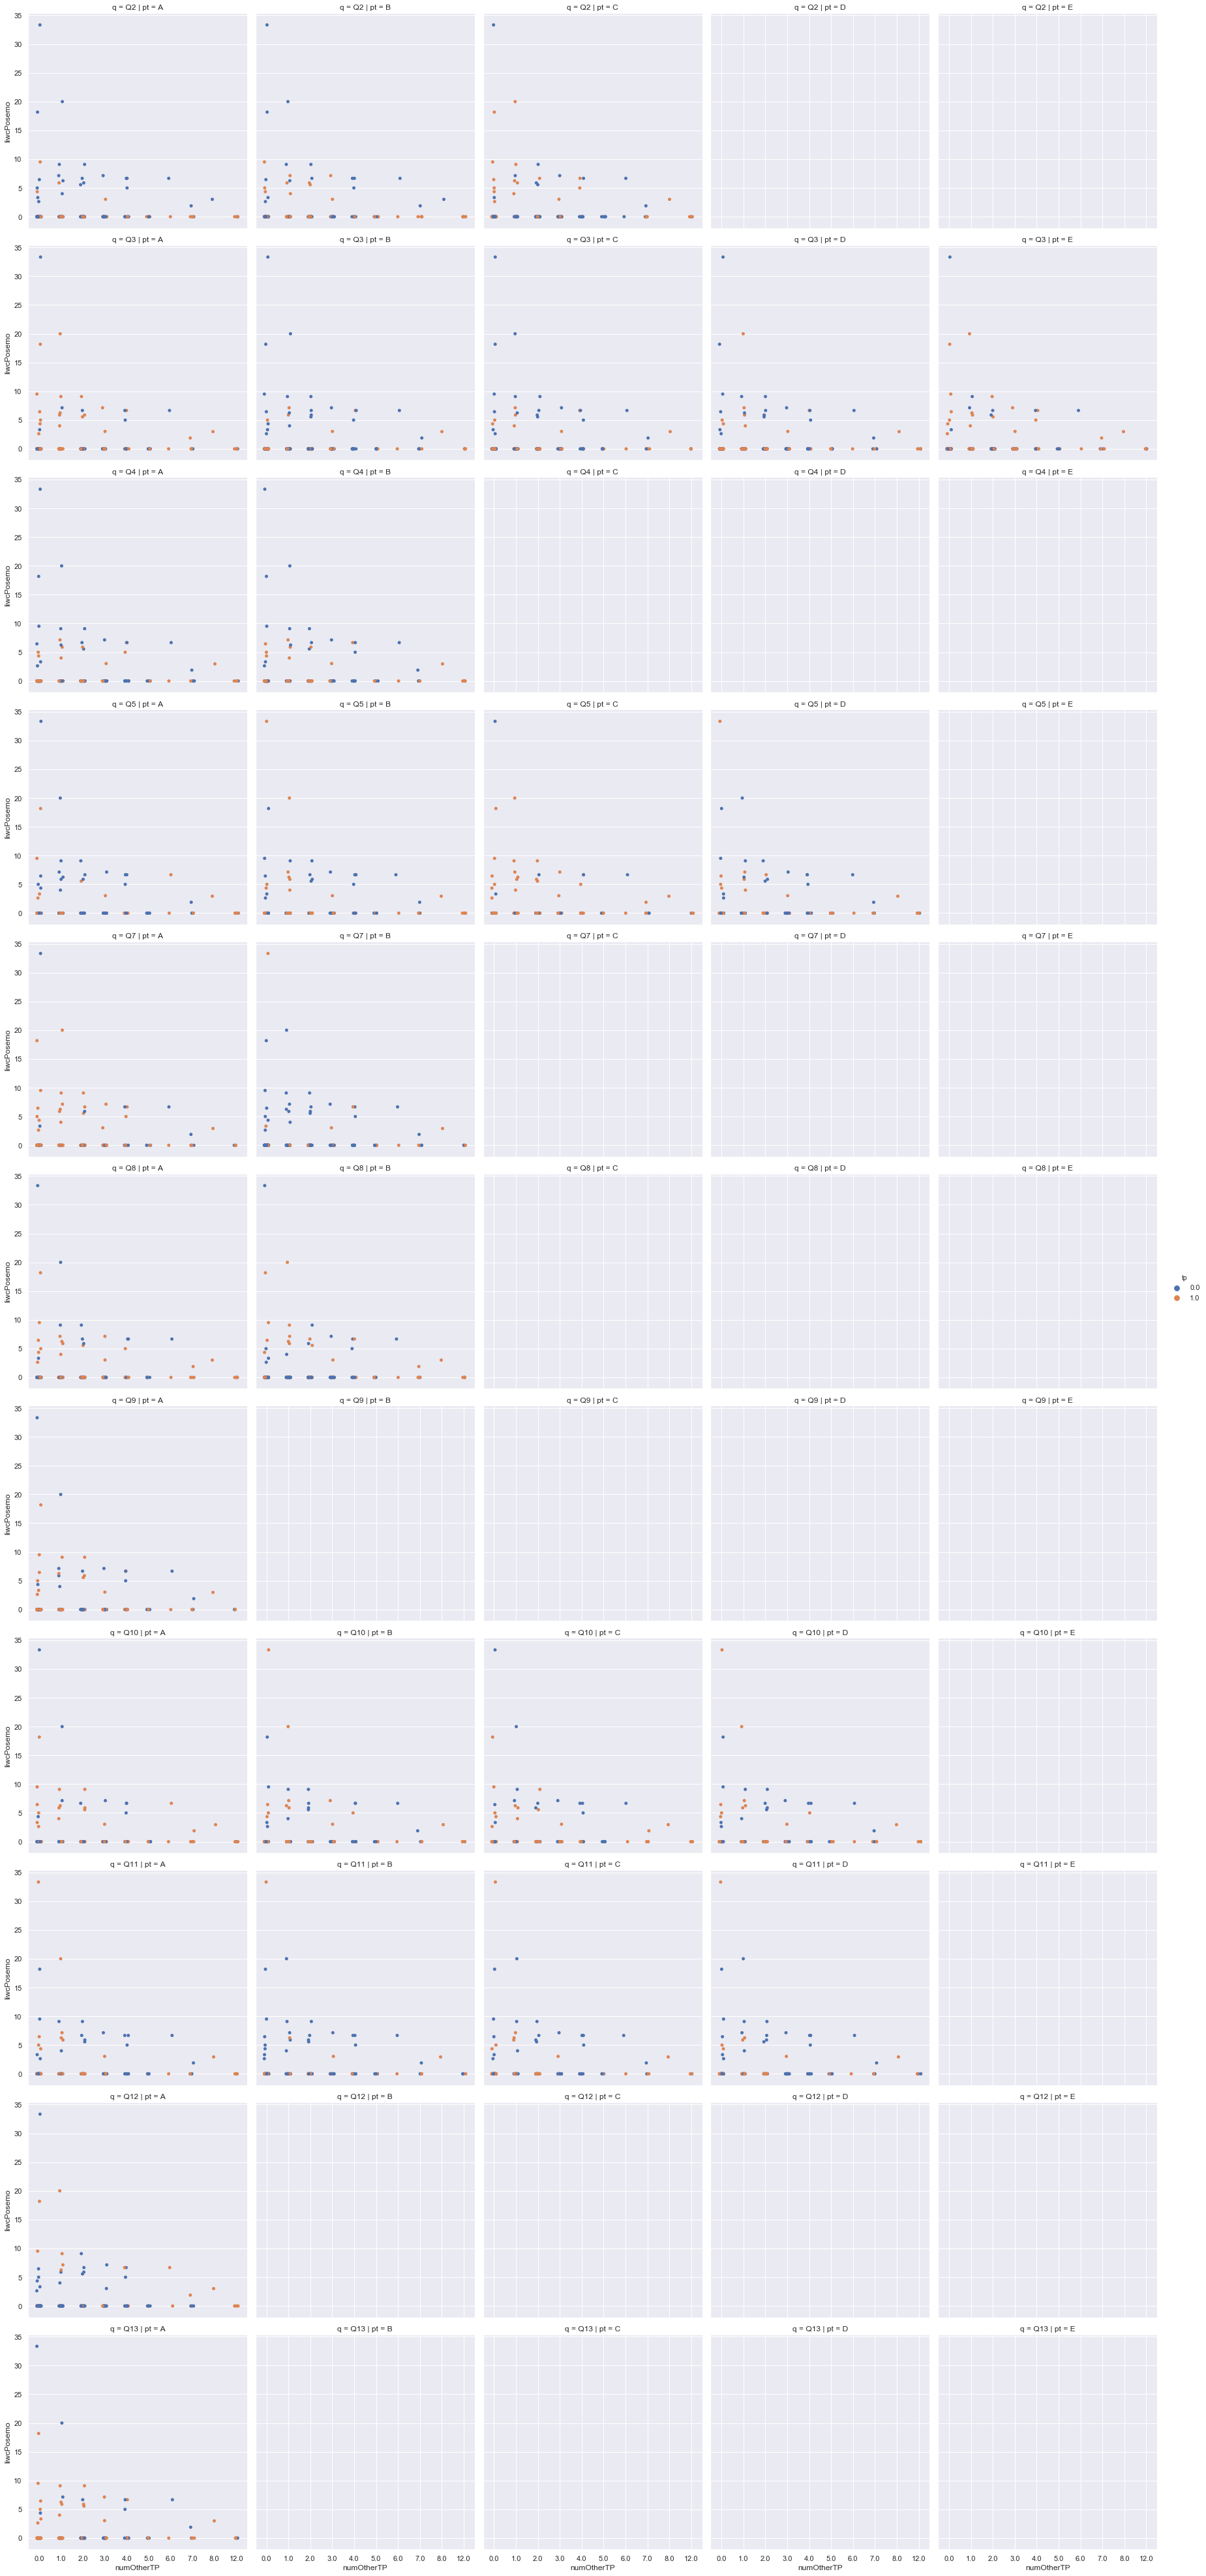

In [131]:
# plot by graph
sns.catplot(y="liwcPosemo", x="numOtherTP", hue="tp",
            col="pt", row="q", data=dropped)

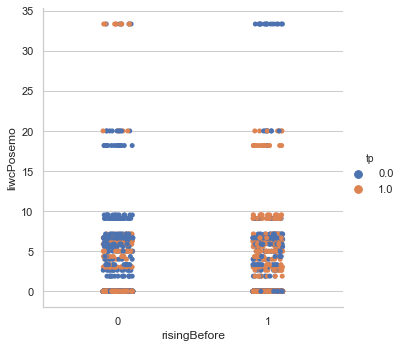

In [217]:
sns.catplot(x="risingBefore", y="liwcPosemo", hue="tp", data=dropped)

# Todo

 * Uncertainty estimates for classifiers stratified by groupid/subj
 * How do feature importances work in decision tree and random forest?
 * Look at SHAP values
 * Boxplots/violin plots for 2 most important features
 * Heatmaps instead of scatterplots

In [ ]:
# feature scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fit our model to training set 
classifier = classifier.fit(X_train, y_train)

# Predict test set results
y_pred = classifier.predict(X_test)

In [214]:
# Visualising the Training set results
X1, X2 = np.meshgrid(np.arange(start = X_train.iloc[:, 0].min() - 1, stop = X_train.iloc[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_train.iloc[:, 1].min() - 1, stop = X_train.iloc[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_train[y_train == j, 0], X_train[y_train == j, 1],
                label = j)
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('numOtherTP')
plt.ylabel('liwcPosemo')
plt.legend()
plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 15 and input n_features is 2 